In [1]:
# Python calculation for the example and exercise from Lecture 4 notes
import numpy as np
import pandas as pd
import scipy.stats as stat
from scipy.interpolate import interp1d
import statistics
from statistics import NormalDist

N_MC = 100000
CONF_LVL = 95

# 1. Swap

In [2]:
sofr_curve = pd.read_csv("data/sofr_curve.csv")
sofr_curve_tenors = sofr_curve[['T','Tenor']]
sofr_curve = sofr_curve.drop(['T','Tenor','Unnamed: 253'], axis=1).T
sofr_curve.columns = sofr_curve_tenors['T']
sofr_curve.index = pd.to_datetime(sofr_curve.index, dayfirst=True).date
sofr_curve = sofr_curve.sort_index()
sofr_curve

/var/folders/ys/nqq2g2_n2td1rcfs2z3h80zm0000gn/T/ipykernel_7707/2426952476.py:5: UserWarning: Parsing dates in %Y%m%d format when dayfirst=True was specified. Pass `dayfirst=False` or specify a format to silence this warning.
  sofr_curve.index = pd.to_datetime(sofr_curve.index, dayfirst=True).date


T,0.002778,0.083333,0.166667,0.250000,0.500000,0.750000,1.000000,2.000000,3.000000,4.000000,...,15.000000,16.000000,17.000000,18.000000,19.000000,20.000000,25.000000,30.000000,35.000000,40.000000
2022-10-31,0.039191,0.038721,0.038670,0.040536,0.044577,0.046004,0.046449,0.044583,0.042002,0.040318,...,0.037151,0.037057,0.036907,0.036698,0.036433,0.036111,0.034091,0.032350,0.030552,0.028708
2022-11-01,0.039604,0.039023,0.038886,0.040725,0.044849,0.046448,0.046970,0.045022,0.042344,0.040614,...,0.036802,0.036682,0.036511,0.036287,0.036010,0.035678,0.033645,0.031979,0.030238,0.028478
2022-11-02,0.039948,0.039286,0.039100,0.040852,0.044884,0.046580,0.047203,0.045496,0.042749,0.040868,...,0.036855,0.036701,0.036498,0.036248,0.035953,0.035613,0.033627,0.031936,0.030292,0.028608
2022-11-03,0.040389,0.039585,0.039350,0.041154,0.045281,0.047107,0.047894,0.046594,0.043833,0.041825,...,0.037221,0.037069,0.036886,0.036657,0.036372,0.036022,0.033811,0.032134,0.030407,0.028655
2022-11-04,0.045965,0.042343,0.038795,0.040611,0.045212,0.046752,0.047500,0.046097,0.043385,0.041503,...,0.037687,0.037557,0.037380,0.037152,0.036870,0.036534,0.034424,0.032558,0.030723,0.028933
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-10-24,0.053105,0.053084,0.053202,0.053424,0.053690,0.053293,0.052503,0.048399,0.045999,0.044850,...,0.044093,0.044056,0.043972,0.043841,0.043663,0.043437,0.041874,0.040238,0.038438,0.036493
2023-10-25,0.052981,0.053057,0.053259,0.053490,0.053749,0.053393,0.052653,0.048791,0.046595,0.045594,...,0.045289,0.045268,0.045198,0.045078,0.044906,0.044683,0.043076,0.041358,0.039564,0.037641
2023-10-26,0.053047,0.053089,0.053218,0.053414,0.053567,0.053089,0.052243,0.048044,0.045645,0.044538,...,0.044269,0.044244,0.044171,0.044049,0.043882,0.043668,0.042182,0.040589,0.038760,0.036764
2023-10-27,0.052989,0.053040,0.053185,0.053368,0.053486,0.052991,0.052115,0.047758,0.045284,0.044200,...,0.044460,0.044461,0.044411,0.044309,0.044157,0.043955,0.042508,0.040985,0.039167,0.037148


1. Full revaluation formula of the payer swap:
- Forward Rate:
$$
    F_{i}(t) = \dfrac{D_{i}(t)-D_{i+1}(t)}{\Delta_{i} \cdot D_{i+1}(t)}
$$
- Floating Leg PV:
\begin{equation*}
  \begin{split}
    PV_{flt} &= \sum^{10}_{i=1} \Delta_{i-1} \cdot F_{i-1}(t) \cdot D_i(t) \\
    &= 1 - D_{10}(t)
  \end{split}
\end{equation*}

- Fixed Leg PV:
\begin{equation*}
  \begin{split}
    PV_{fix} &= R_{swap} \sum^{10}_{i=1} \Delta_{i-1} \cdot D_i(t) \\
    &= R_{swap} \cdot PV01
  \end{split}
\end{equation*}

- Payer swap PV:
\begin{equation*}
  \begin{split}
    PV_{payer} &= Notional \cdot (PV_{flt} - PV_{fix}) \\
    & = Notional \cdot [1 - D_{10}(t) - R_{swap} \cdot PV01]
  \end{split}
\end{equation*}



2. Sensitivity based revaluation formula of the payer swap:
- According to swap PV formula:
$$
PV_{payer} = Notional \cdot [1 - D_{10}(t) - R_{swap} \cdot PV01]
$$
- and chain rule:
$$
  \frac{\partial PV01}{\partial Z_i(t)} = \frac{\partial PV01}{\partial D_i(t)} \cdot \frac{\partial D_i(t)}{\partial Z_i(t)}
$$
- where 
\begin{equation*}
  \begin{split}
  \frac{\partial PV01}{\partial D_i(t)} &=\Delta_{i-1} = 1 \\
  \frac{\partial D_i(t)}{\partial Z_i(t)} &= - T_i \cdot e^{-Z_i(t)T_i} = - T_i \cdot D_i(t)
  \end{split}
\end{equation*}
- Put together we get the sensitivity of swap PV to zero rates:
\begin{equation*}
  \begin{split}
  \frac{\partial PV_{swap}}{\partial Z_i(t)} =\begin{cases}
      Notional \cdot T_i \cdot D_i(t) \cdot R_{swap}, & i=1,2,...,9\\
      Notional \cdot T_i \cdot D_i(t) \cdot (1 + R_{swap}) , & i=10
    \end{cases}
  \end{split}
\end{equation*}


In [3]:
def get_discount_curve(
        zero_rates:list,
        tenors:list # day count fraction from today to each payment day
        ):
    assert len(zero_rates) == len(tenors), f"Expect {len(tenors)} zero rates, got {len(zero_rates)}."
    Z = np.array(zero_rates)
    T = np.array(tenors)
    return np.exp(-Z*T)


def get_forward_curve(
        zero_rates:list,
        tenors:list, 
        interval=1, # day count fraction of the interval between payment days
        ):
    DF = get_discount_curve(zero_rates, tenors)
    DF_start = np.concatenate([[1], DF[:-1]]) # first DF=1. we dont consider forward swap here
    DF_end = DF
    F = (DF_start - DF_end) / (DF_end * interval)
    return F
    

def get_payer_swap_pv(
        zero_rates:list,
        tenors:list,
        forward_rates:list=None,
        swap_rate=0.042,
        interval=1, 
        notional=100*1000000
        ):
    DF = get_discount_curve(zero_rates, tenors)
    F = get_forward_curve(zero_rates, tenors) if forward_rates is None else np.array(forward_rates)
    pv_fix = swap_rate*sum(interval*DF)
    pv_flt = sum(interval*F*DF)
    return notional*(pv_flt - pv_fix)


def swap_pnl_1d_full(
        zero_rates_t0:list,
        zero_rates_t1:list,
        tenors:list
    ):
    pv_t0 = get_payer_swap_pv(zero_rates_t0, tenors)
    pv_t1 = get_payer_swap_pv(zero_rates_t1, tenors)
    return pv_t1 - pv_t0


def swap_pnl_1d_sens(
        zero_rates_t0:list,
        zero_rates_chng:list,
        tenors:list,
        swap_rate=0.042,
        notional=100*1000000
        ):    
    zero_rates_chng = np.array(zero_rates_chng)
    tenors = np.array(tenors)
    DF_t0 = get_discount_curve(zero_rates_t0, tenors)
    W = notional * swap_rate * tenors * DF_t0  # weight of risk factors in PnL sensitivity
    W[-1] = notional * (1+swap_rate) * tenors[-1] * DF_t0[-1]
    return W @ zero_rates_chng




In [471]:
# check point - swap PV as of t=0 (today)
# sofr_curve_t0 = sofr_curve.iloc[-1]
# swap_tenors_t0 = range(1,10+1)
# swap_zero_rates_t0 = sofr_curve_t0[swap_tenors_t0].values
# swap_pv_t0 = get_payer_swap_pv(swap_zero_rates_t0, swap_tenors_t0)
# swap_pv_t0


2442901.699359046

In [5]:
# Monte Carlo VaR
# using absolute daily change (bps) in SOFA curve
abs_chng_sofr = \
    (sofr_curve.diff()*10000)\
    .dropna()\
    .reset_index(drop=True)

corr_sofr = abs_chng_sofr.corr().values
cov_sofr = abs_chng_sofr.cov().values
mean_sofr = abs_chng_sofr.mean().values
std_sofr = abs_chng_sofr.std().values

In [6]:
# generate correlated normal distributions
factor_loadings = np.linalg.cholesky(corr_sofr)
n_sofr = abs_chng_sofr.shape[1]
np.random.seed(29)
uni_rand = np.random.uniform(size=(N_MC, n_sofr))
vfunc_inv_cdf = np.vectorize(NormalDist().inv_cdf)
norm_rand = vfunc_inv_cdf(uni_rand)
corr_norm_rand = norm_rand @ (factor_loadings.T)

In [ ]:
# check point - sample correlation 
# i1 = 1
# i2 = 3
# s1 = [ r[i1] for r in corr_norm_rand ]
# s2 = [ r[i2] for r in corr_norm_rand ]
# print(statistics.correlation(s1, s2)) # should be close to the value in corr matrix
# print(corr_sofr[i1][i2]) 

-0.055749804908508824
-0.05439349191518428


In [8]:
# generate SOFR curve based on MC samples
abs_chng_sofr_mc = (corr_norm_rand * std_sofr.reshape(1,-1)) + mean_sofr

sofr_curve_t0 = sofr_curve.iloc[-1]
swap_tenors = range(1,10+1)
swap_zero_rates_t0 = sofr_curve_t0[swap_tenors].values

swap_pnl_1d_full_mc = []
swap_pnl_1d_sens_mc = []
for delta in abs_chng_sofr_mc: # abs_chng_sofr_mc[[0]] # for test
    swap_zero_rates_delta = delta[swap_tenors]/10000 # delta is in bps
    swap_zero_rates_t1 = swap_zero_rates_t0 + swap_zero_rates_delta
    pnl_full = swap_pnl_1d_full(swap_zero_rates_t0,
                                swap_zero_rates_t1,
                                swap_tenors
                                )
    pnl_sens = swap_pnl_1d_sens(swap_zero_rates_t0,
                                swap_zero_rates_delta,
                                swap_tenors
                                )
    swap_pnl_1d_full_mc.append(pnl_full)
    swap_pnl_1d_sens_mc.append(pnl_sens)

print(np.mean(swap_pnl_1d_full_mc))
print(np.mean(swap_pnl_1d_sens_mc))

12621.439950104597
15148.276972842463


# 2. Stocks

In [9]:
S_appl = pd.read_csv("data/AAPL.csv").set_index('Date')
S_boa = pd.read_csv("data/BAC.csv").set_index('Date')
S_ford = pd.read_csv("data/F.csv").set_index('Date')
S_msft = pd.read_csv("data/MSFT.csv").set_index('Date')

S_appl.index = pd.to_datetime(S_appl.index, dayfirst=True).date
S_boa.index = pd.to_datetime(S_boa.index, dayfirst=True).date
S_ford.index = pd.to_datetime(S_ford.index, dayfirst=True).date
S_msft.index = pd.to_datetime(S_msft.index, dayfirst=True).date

S_appl = S_appl.sort_index()
S_boa = S_boa.sort_index()
S_ford = S_ford.sort_index()
S_msft = S_msft.sort_index()

/var/folders/ys/nqq2g2_n2td1rcfs2z3h80zm0000gn/T/ipykernel_7707/3450744268.py:6: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  S_appl.index = pd.to_datetime(S_appl.index, dayfirst=True).date
/var/folders/ys/nqq2g2_n2td1rcfs2z3h80zm0000gn/T/ipykernel_7707/3450744268.py:7: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  S_boa.index = pd.to_datetime(S_boa.index, dayfirst=True).date
/var/folders/ys/nqq2g2_n2td1rcfs2z3h80zm0000gn/T/ipykernel_7707/3450744268.py:8: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  S_ford.index = pd.to_datetime(S_ford.index, dayfirst=True).date
/var/fold

In [10]:
# combine 4 stock prices into a return matrix, w same date range
offset = \
    min(
        S_appl.index.min(),
        S_boa.index.min(),
        S_ford.index.min(),
        S_msft.index.min()
    )

idx_appl = ((S_appl.index - offset) / pd.offsets.Day(1)).to_list()
idx_boa = ((S_boa.index - offset) / pd.offsets.Day(1)).to_list()
idx_ford = ((S_ford.index - offset) / pd.offsets.Day(1)).to_list()
idx_msft = ((S_msft.index - offset) / pd.offsets.Day(1)).to_list()

interp_appl =  interp1d(idx_appl, S_appl['Adj Close'].to_list())
interp_boa =  interp1d(idx_boa, S_boa['Adj Close'].to_list())
interp_ford =  interp1d(idx_ford, S_ford['Adj Close'].to_list())
interp_msft =  interp1d(idx_msft, S_msft['Adj Close'].to_list())

In [11]:
idx_all = list(set(idx_appl + idx_boa + idx_ford + idx_msft)) # to merge the index of all 4 stocks
idx_all = sorted(idx_all)
# relative daily change of the 4 stocks
R_stocks = \
    pd.DataFrame(
        {
            'appl': pd.Series(interp_appl(idx_all)).pct_change().dropna(),
            'boa': pd.Series(interp_boa(idx_all)).pct_change().dropna(),
            'ford': pd.Series(interp_ford(idx_all)).pct_change().dropna(),
            'msft': pd.Series(interp_msft(idx_all)).pct_change().dropna()
        }
        )
R_stocks

,appl,boa,ford,msft
1,-0.017543,0.004439,0.002244,-0.017059
2,-0.037305,-0.003039,-0.025373,-0.035368
3,-0.042405,-0.005542,0.015314,-0.026579
4,-0.001947,0.025077,0.018854,0.033326
5,0.003902,0.005980,0.014064,0.029270
...,...,...,...,...
246,0.002543,-0.003911,-0.007840,0.003674
247,-0.013492,0.003141,0.013169,0.030678
248,-0.024606,0.022309,-0.016464,-0.037514
249,0.007969,-0.036371,-0.122467,0.005856


In [462]:
# combined 4 stocks price
# S_stocks = \
#     pd.DataFrame(
#         {
#             'appl': pd.Series(interp_appl(idx_all)),
#             'boa': pd.Series(interp_boa(idx_all)),
#             'ford': pd.Series(interp_ford(idx_all)),
#             'msft': pd.Series(interp_msft(idx_all))
#         }
#         )
# S_stocks.to_csv("data/stocks_hist_data.csv")

In [12]:
# Monte Carlo VaR
# using relative daily change of the stocks
corr_stocks = R_stocks.corr().values
cov_stocks = R_stocks.cov().values
mean_stocks = R_stocks.mean().values
std_stocks = R_stocks.std().values

# generate correlated normal distributions
factor_loadings = np.linalg.cholesky(corr_stocks)
n_stocks = R_stocks.shape[1]
np.random.seed(329)
uni_rand = np.random.uniform(size=(N_MC, n_stocks))
vfunc_inv_cdf = np.vectorize(NormalDist().inv_cdf)
norm_rand = vfunc_inv_cdf(uni_rand)
corr_norm_rand = norm_rand @ (factor_loadings.T)

In [ ]:
# check point - sample correlation 
# i1 = 1
# i2 = 3
# s1 = [ r[i1] for r in corr_norm_rand ]
# s2 = [ r[i2] for r in corr_norm_rand ]
# print(statistics.correlation(s1, s2))
# print(corr_stocks[i1][i2])

0.23784464123628424
0.2385795704860709


In [14]:
def stocks_pnl_1d_full(R, 
                       W=[1E6, 1E6, 1E6, 1E6]
                       ):
    assert len(R) == 4, f"Expect 4 stock returns, got {len(R)}."
    return (W[0]*((1+R[0])-1) + W[1]*((1+R[1])-1) + W[2]*((1+R[2])-1) + W[3]*((1+R[3])-1))

def stocks_pnl_1d_sens(R, 
                       W=[1E6, 1E6, 1E6, 1E6]
                       ):
    assert len(R) == 4, f"Expect 4 stock returns, got {len(R)}."
    return R@W

In [15]:
# generate stock returns based on MC samples
R_stocks_mc = (corr_norm_rand * std_stocks.reshape(1,-1)) + mean_stocks

stocks_pnl_1d_full_mc = []
stocks_pnl_1d_sens_mc = []
for R in R_stocks_mc:
    pnl_full = stocks_pnl_1d_full(R)
    pnl_sens = stocks_pnl_1d_sens(R)
    stocks_pnl_1d_full_mc.append(pnl_full)
    stocks_pnl_1d_sens_mc.append(pnl_sens)

print(np.mean(stocks_pnl_1d_full_mc))
print(np.mean(stocks_pnl_1d_sens_mc))

416.39985895942107
416.39985895942056


In [16]:
# Full Revaluation
pnl_1d_full_mc =  np.array(swap_pnl_1d_full_mc) + np.array(stocks_pnl_1d_full_mc)
var_1d_full_mc = np.abs(np.percentile(pnl_1d_full_mc, 100-CONF_LVL))

# Sensitivity Revaluation
pnl_1d_sens_mc =  np.array(swap_pnl_1d_sens_mc) + np.array(stocks_pnl_1d_sens_mc)
var_1d_sens_mc = np.abs(np.percentile(pnl_1d_sens_mc, 100-CONF_LVL))

print("============================================================================================================================")
print("Monte Carlo VaR:")
print(f"VaR [1d, {CONF_LVL}%], Full Revaluation: {var_1d_full_mc:,.0f}") 
print(f"VaR [1d, {CONF_LVL}%], Sensitivity: {var_1d_sens_mc:,.0f}") 
print("============================================================================================================================")

Monte Carlo VaR:
VaR [1d, 95%], Full Revaluation: 1,045,197
VaR [1d, 95%], Sensitivity: 1,038,687


Matplotlib is building the font cache; this may take a moment.


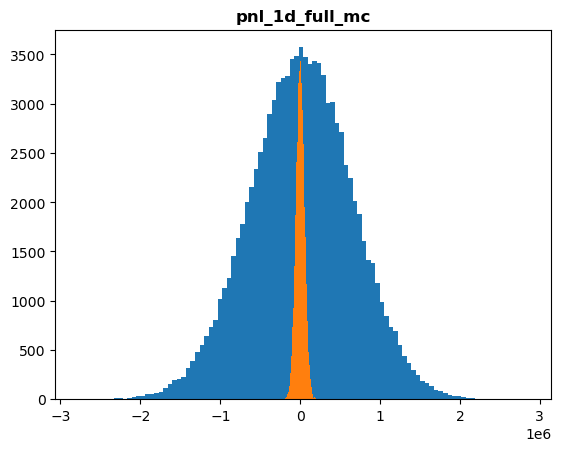

In [17]:
import matplotlib.pyplot as plt

num_bins = 100
plt.hist(pnl_1d_full_mc, num_bins)
plt.hist(stocks_pnl_1d_full_mc, num_bins)

plt.title('pnl_1d_full_mc', fontweight='bold')

plt.show()

# seems variance mostly comes from the swap